<a href="https://colab.research.google.com/github/melissamelton/BachelorAnalysis/blob/main/TheBachelorAnalysis_GSB521.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

# The Bachelor Data Gathering & Cleaning

Obtain a list of the seasons we can scrape data from on Wikipedia:

In [75]:
# The Bachelor has had 26 seasons so far (27 is currently airing so it will not be included)
seasons = np.arange(1, 27, 1)
# seasons 3, 4, and 6-8 do not have contestant data on Wikipedia
missing_table = {3, 4, 6, 7, 8}
# obtain list of season numbers which have contestant data on their wiki page
seasons = [x for x in seasons if x not in missing_table]

We will now use the BeautifulSoup library to scrape data about contestants from Wikipedia.

In [74]:
contestants_df = pd.DataFrame()
urlstart = "https://en.wikipedia.org/wiki/The_Bachelor_(American_season_"

def seasons_scrape(seasons, contestants_df, urlstart):
  # loop through seasons
  for i in range(0, len(seasons)):
    # write the url for specific season
    wikiurl = urlstart + str(seasons[i]) + ")"
    table_class = "wikitable sortable jquery-tablesorter"
    response = requests.get(wikiurl)
    # parse data from html
    soup = BeautifulSoup(response.text, 'html.parser')
    contestant_table = soup.find('table', {'class':"wikitable"})
    df = pd.read_html(str(contestant_table))
    # convert list to dataframe
    df = pd.DataFrame(df[0])
    # add column for the season (value the same for all rows from that season)
    df['Season'] = seasons[i]
    # seasons 1 and 2 have a different label for the Outcome and Occupation columns
    if 'Eliminated' in df.columns and 'Job' in df.columns:
      df.rename(columns = {'Eliminated': 'Outcome',
                           'Job': 'Occupation'}, inplace = True)
    # keep only desired columns
    df = df[['Season', 'Name', 'Age', 'Hometown', 'Occupation', 'Outcome']]
    contestants_df = contestants_df.append(df, ignore_index = True)
  return contestants_df


In [76]:
contestants_df = seasons_scrape(seasons, contestants_df, urlstart)

Unfortunately, full contestant data cannot be found online for seasons 3, 4, 6, 7, and 8 (even the Bachelor Nation fandom Wiki does not have it). So, our resulting dataframe only represents 21 of the 26 full seasons.

Perform some clean-up on the contestants_df dataframe.

In [68]:
# sometimes contestants will leave one week then return a later week. Remove the
# rows from the table which reference them leaving (the info we care about is stored
# in another row, including their final placement)
contestants_df[contestants_df['Age'] == "(Returned to competition)"]

# remove these rows -- the data for these contestants is still in the table, just a different row
contestants_df = contestants_df[contestants_df['Age'] != "(Returned to competition)"]

In [69]:
# some contestants' names had hyperlinks. Remove the references attached
contestants_df['Name'] = contestants_df['Name'].apply(lambda x: x.split('[')[0]
                                                      if '[' in x else x)
# separate town and state into their own columns
hometowns = contestants_df['Hometown'].str.split(',', expand = True)
contestants_df[['Town', 'State']] = hometowns.iloc[:, :-1]
# make sure age is numeric
contestants_df['Age'] = pd.to_numeric(contestants_df['Age'])

# keep desired columns
cols = ['Season', 'Name', 'Age', 'Town', 'State', 'Occupation', 'Outcome']
contestants_df = contestants_df[cols]

In [70]:
contestants_df

,Season,Name,Age,Town,State,Occupation,Outcome
0,1,Amanda Marsh,23.0,Chanute,Kansas,Event Planner,Winner
1,1,Trista Rehn,29.0,Miami,Florida,Miami Heat Dancer,Runner-up
2,1,Shannon Oliver,24.0,Dallas,Texas,Financial Management Consultant,Week 5
3,1,Kim,24.0,Tempe,Arizona,Nanny,Week 4
4,1,Cathy Grimes,22.0,Terre Haute,Indiana,Graduate Student,Week 3
...,...,...,...,...,...,...,...
578,26,Jane Paik,33.0,Los Angeles,California,Social Media Director,Week 1
579,26,Lindsay Dobbs,27.0,Warner Robins,Georgia,Neonatal Nurse,Week 1
580,26,Rianna Hockaday,26.0,Mount Pleasant,Texas,Registered Nurse,Week 1
581,26,Samantha Jeffries,26.0,Dayton,Ohio,Occupational Therapist,Week 1


Create a new data frame representing all winners of the show. Note: Season 11 notoriously does not have a winner--that season's bachelor Brad Womack infamously broke up with both his final two women!

Create another new data frame with the top four contestants from each season.

In [ ]:
# winners
winners_df = contestants_df[contestants_df['Outcome'] == "Winner"]

# top 4
top4_df = contestants_df.groupby('Season').head(4)

potential categories for jobs: marketing, teacher, nurse, cheerleader/dancer, beauty/styling (hairstylist, esthetician, stylist), sales, real estate, arts (graphic designer, creative director, photographer, videographer), therapist (psychologist, therapist, speech pathologist), dental, flight (flight attendant or instructor), attorney?

In [ ]:
# set up words we will use for detecting categories
marketing = ['Marketing', 'Content', 'Publicist', 'Communications', 'Social Media']
sales = ['Sales', 'Salesperson']
teacher = ['Teacher']
nurse = ['Nurse']
dance = ['Dancer', 'Dance Instructor', 'Cheerleader']
therapy = ['Psychologist', 'Therapist', 'Speech Pathologist']
dental = ['Dental']
realestate = ['Real Estate', 'Realtor']
attorney = ['Attorney']
flight = ['Flight']
arts = ['Graphic Designer', 'Creative Director', 'Photographer', 'Videographer']
beauty = ['Stylist', 'Hairstylist', 'Esthetician']
events = ['Event Planner']
model = ['Model']

# create a dictionary of job categories, with the values representing the list of jobs within the key
job_dictionary = {'Marketing': marketing, 'Sales': sales, 'Teaching': teacher, 
                  'Nursing': nurse, 'Dance': dance, 'Therapy': therapy,
                  'Dental Care': dental, 'Real Estate': realestate, 'Legal': attorney, 
                  'Flight': flight, 'Arts': arts, 'Beauty': beauty, 
                  'Events': events, 'Modeling': model}

Create a new column in the top4_df and winners_df data frames to input the job category of each contestant.

In [ ]:
top4_df.insert(7, 'Job Category', '')
winners_df.insert(7, 'Job Category', '')

This function will look at the occupation of each contestant in a data frame and then look through each key, value pair in the job_dictionary. If the contestant's occupation matches a job in one of the keys, the name of that key will be inputted as their job category. If the contestant's job does not appear in the dictionary, the category will be designated as "Other".

In [ ]:
def detect_category(df):
  for i in range(0, len(df)):
    contestant_job = df.iloc[i, 5]
    for key, value in job_dictionary.items():
      for job in value:
        if job.casefold() not in contestant_job.casefold():
          continue
        else:
          df.iloc[i,7] = key
    if df.iloc[i, 7] not in job_dictionary:
      df.iloc[i,7] = 'Other'
  return df

top4_df = detect_category(top4_df)
winners_df = detect_category(winners_df)

In [ ]:
top4_df['Job Category'].value_counts()
#winners_df['Job Category'].value_counts()

Other        3
Arts         3
Events       2
Therapy      2
Teaching     2
Marketing    2
Modeling     2
Nursing      2
Sales        1
Flight       1
Name: Job Category, dtype: int64

In [ ]:
top4_df['Age'].value_counts()

24.0    14
26.0    14
25.0    14
23.0    12
27.0     8
28.0     8
29.0     5
22.0     3
32.0     3
31.0     2
30.0     1
Name: Age, dtype: int64

# The Bachelorette Data Gathering & Cleaning

Once again, we create an array representing the seasons we can obtain data from on Wikipedia. Thankfully this time, all seasons have contestant data available.

In [77]:
# The Bachelorette has had 19 seasons so far
seasons = np.arange(1, 20, 1)

Use the BeautifulSoup library to create a data frame containing information on all Bachelorette contestants, using the seasons_scrape() function from the prior section.

In [78]:
contestants_df2 = pd.DataFrame()
urlstart = "https://en.wikipedia.org/wiki/The_Bachelorette_(American_season_"

contestants_df2 = seasons_scrape(seasons, contestants_df2, urlstart)

Perform some clean-up on the contestants dataframe:

In [81]:
# sometimes contestants will leave one week then return a later week. Remove the
# rows from the table which reference them leaving (the info we care about is stored
# in another row, including their final placement)
contestants_df2[contestants_df2['Age'] == "(Returned to competition)"]

# remove these rows -- the data for these contestants is still in the table, just a different row
contestants_df2 = contestants_df2[contestants_df2['Age'] != "(Returned to competition)"]

contestants_df2 = contestants_df2.dropna(axis=0)

In [82]:
# some contestants' names had hyperlinks. Remove the references attached
contestants_df2['Name'] = contestants_df2['Name'].apply(lambda x: x.split('[')[0] if '[' in x else x)
# fix some unclean age values
contestants_df2['Age'] = contestants_df2['Age'].apply(str).apply(lambda x: x.split('[')[0] if '[' in x else x)
# separate town and state into their own columns
hometowns = contestants_df2['Hometown'].str.split(',', expand = True)
contestants_df2[['Town', 'State']] = hometowns
# make sure age is numeric
contestants_df2['Age'] = pd.to_numeric(contestants_df2['Age'])

# keep desired columns
cols = ['Season', 'Name', 'Age', 'Town', 'State', 'Occupation', 'Outcome']
contestants_df2 = contestants_df2[cols]

In [83]:
contestants_df2

,Season,Name,Age,Town,State,Occupation,Outcome
0,1,Ryan Sutter,28,Vail,Colorado,Firefighter,Winner
1,1,Charlie Maher,28,Hermosa Beach,California,Financial Analyst,Runner-up
2,1,Russell Woods,31,San Rafael,California,Writer,Week 5
3,1,Greg Todtman,28,Manhattan,New York,Importer,Week 4
4,1,Bob Guiney,31,Ferndale,Michigan,Mortgage Broker,Week 3
...,...,...,...,...,...,...,...
525,19,Chris Austin,30,Redondo Beach,California,Mentality Coach,Week 2
526,19,Jordan Vandergriff,27,Alpharetta,Georgia,Drag Racer,Week 2
527,19,Joey Young,24,Brookfield,Connecticut,Twin,Week 1
528,19,Justin Young,24,Brookfield,Connecticut,Other Twin,Week 1


Create two new data frames for the winners and top 4 of each season:

In [84]:
# winners
winners_df2 = contestants_df2[contestants_df2['Outcome'] == "Winner"]

# top 4
top4_df2 = contestants_df2.groupby('Season').head(4)

# Visualization of Contestant Demographics

## Contestants by Age

## Contestants by Occupation

## Contestants by Home State

# Visualization of Relationship Status

In [105]:
bachelors = {'Season': np.arange(1,27,1),
             'Name': ['Alex Michel', 'Aaron Buerge', 'Andrew Firestone', 
                           'Bob Guiney', 'Jesse Palmer', 'Byron Velvick',
                           "Charlie O'Connell", 'Travis Lane Stork', 'Lorenzo Borghese',
                           'Andy Baldwin', 'Brad Womack', 'Matt Grant',
                           'Jason Mesnick', 'Jake Pavelka', 'Brad Womack',
                           'Ben Flajnik', 'Sean Lowe', 'Juan Pablo Galavis',
                           'Chris Soules', 'Ben Higgins', 'Nick Viall',
                           'Arie Luyendyk Jr.', 'Colton Underwood', 'Peter Weber',
                           'Matt James', 'Clayton Echard'],
                  'Relationship Status': ['Broken Up', 'Broken Up', 'Broken Up',
                                          'Broken Up', 'Broken Up', 'Broken Up',
                                          'Broken Up', 'Broken Up', 'Broken Up',
                                          'Broken Up', 'Broken Up', 'Broken Up',
                                          'Together with Runner-Up', 'Broken Up', 'Broken Up',
                                          'Broken Up', 'Together with Winner', 'Broken Up',
                                          'Broken Up', 'Broken Up', 'Broken Up',
                                          'Together with Runner-Up', 'Broken Up', 'Broken Up',
                                          'Together with Winner', 'Broken Up'],
                  'Relationship Length in Years': [8/12, 3/12, 7/12,
                                          1/12, 1/12, 5,
                                          59/12, 1/12, 2/12,
                                          4/12, 0, 2/12,
                                          14, 3/12, 3/12,
                                          7/12, 11, 7/12,
                                          2/12, 14/12, 5/12,
                                          5, 14/12, 0,
                                          2, 6/12],
                  'Height in Inches': [73, 72, 70,
                                       73, 74, 74,
                                       75, 75, 71,
                                       72, 73, 77,
                                       72, 70, 73,
                                       74, 75, 71,
                                       73, 76, 74,
                                       74, 75, 73,
                                       77, 77]}
bachelors_df = pd.DataFrame(bachelors)
bachelors_df.head()

,Season,Name,Relationship Status,Relationship Length in Years,Height in Inches
0,1,Alex Michel,Broken Up,0.666667,73
1,2,Aaron Buerge,Broken Up,0.250000,72
2,3,Andrew Firestone,Broken Up,0.583333,70
3,4,Bob Guiney,Broken Up,0.083333,73
4,5,Jesse Palmer,Broken Up,0.083333,74


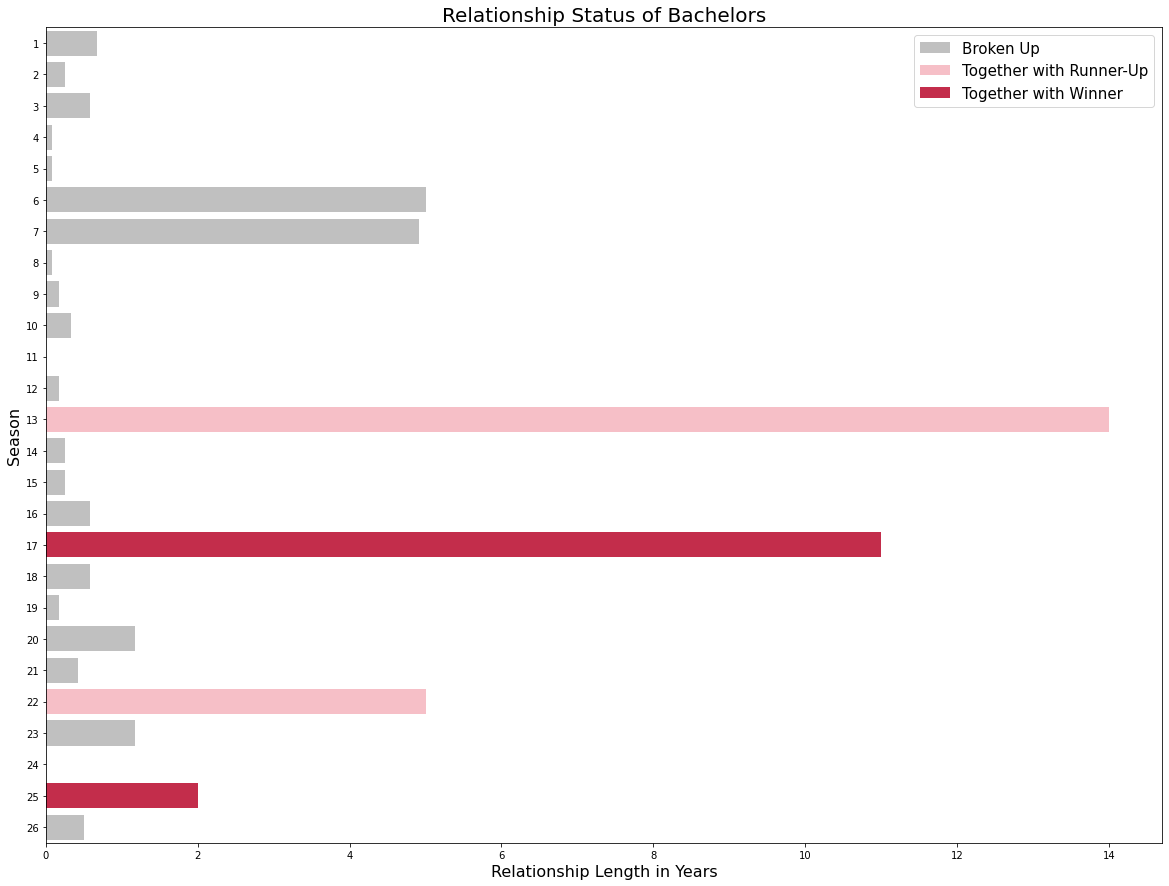

In [127]:
colors = {'Broken Up': 'silver', 
          'Together with Runner-Up': 'lightpink', 
          'Together with Winner': 'crimson'}

plt.figure(figsize = (20,15))
plt.title('Relationship Status of Bachelors', fontsize = 20)
plt.xlabel('Season', fontsize = 16)
plt.ylabel('Relationship Length (Years)', fontsize = 16)

sns.barplot(y = bachelors_df['Season'].apply(str), x = bachelors_df['Relationship Length in Years'],
         hue = bachelors_df['Relationship Status'], palette = colors, dodge = False)
plt.legend(loc = 'upper right', fontsize = 15)